<a href="https://colab.research.google.com/github/HemaKumar0077/Autism-Detection-by-image/blob/main/Autism_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Dependencies and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os as os

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
tf.config.list_physical_devices('GPU')

[]

2. Remove Unwanted images

In [3]:
import cv2
import imghdr

C:\Users\hemur\AppData\Local\Temp\ipykernel_21184\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [24]:
!pip install opencv-python


In [6]:
data_dir = "C:/Retinal-image-analysis/Retinal Fundus Images_medium"

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [27]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

KeyboardInterrupt: 

In [10]:
os.listdir(data_dir)

['1.Dry AMD',
 '10.Glaucoma',
 '11.Normal Fundus',
 '2.Wet AMD',
 '3.Mild DR',
 '4.Moderate DR',
 '5.Severe DR',
 '6.Proliferate DR',
 '7.Cataract',
 '8.Hypertensive Retinopathy',
 '9.Pathological Myopia']

# 3. Load **Data**

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory("C:/Retinal-image-analysis/Retinal Fundus Images_medium")

Found 10565 files belonging to 11 classes.


In [17]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

In [21]:
batch[0].shape

(32, 256, 256, 3)

In [23]:
#batch[1]

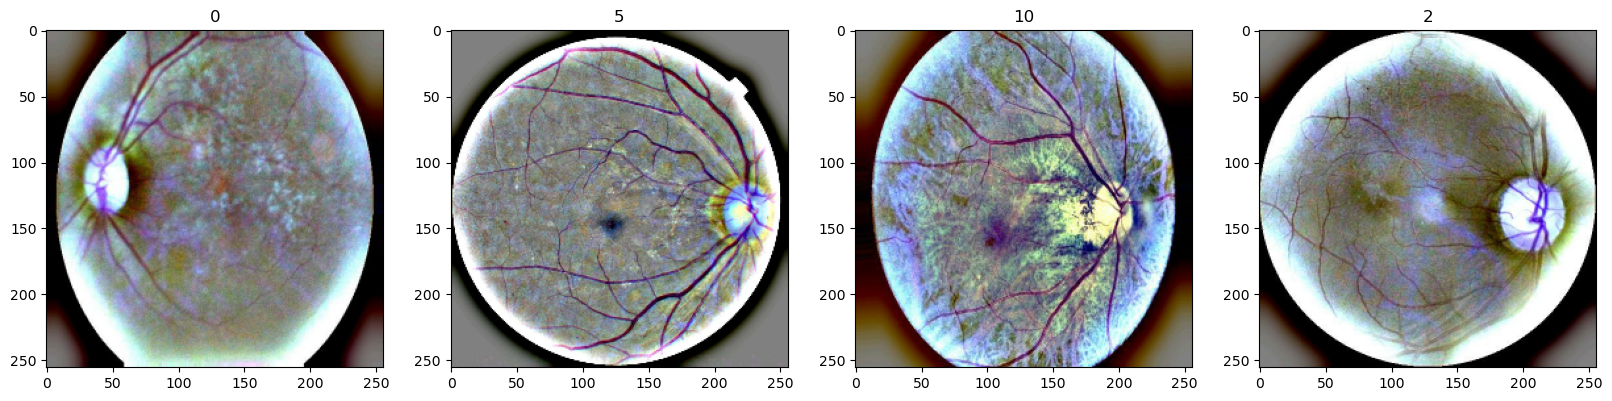

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [28]:
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          ...,
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ]],
 
         [[0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          ...,
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ]],
 
         [[0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          ...,
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ],
          [0.5019608 , 0.5019608 , 0.5019608 ]],
 
         ...,
 
         [[0.5019608 , 0.5019608 , 0.5019608 ],
          [0.50196

In [32]:
batch[0].max()

255.0

In [34]:
len(data)

331

5. Split Data

In [37]:
train_size = int(len(data)*.75)+1
val_size = int(len(data)*.15)
test_size = int(len(data)*.1)

In [39]:
train_size+val_size+test_size

331

In [41]:
train_size

249

In [43]:
val_size

49

In [45]:
test_size

33

In [47]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#6. Build Deep Learning Model

In [50]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a residual block
def residual_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    shortcut = input_tensor
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Input
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Initial convolutional layer
x = Conv2D(16, (3, 3), strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Add residual blocks
x = residual_block(x, filters=32)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=128)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(11, activation='softmax')(x)  # Updated for 11 classes

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


# Summary



In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 340,779 (1.30 MB)

 Trainable params: 339,403 (1.29 MB)

 Non-trainable params: 1,376 (5.38 KB)

7. Train

In [57]:
logdir='logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
history = model.fit(
    train,  # Ensure train data outputs integer labels (0, 1, ..., 10)
    epochs=50,
    validation_data=val,  # Ensure val data also outputs integer labels
    callbacks=[early_stop, reduce_lr],
    batch_size=32  # Set your preferred batch size here
)



Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.3535 - loss: 1.7123 - val_accuracy: 0.1505 - val_loss: 3.9834 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.5561 - loss: 1.0351 - val_accuracy: 0.2596 - val_loss: 2.7482 - learning_rate: 0.0010
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.6136 - loss: 0.8730 - val_accuracy: 0.3010 - val_loss: 2.8184 - learning_rate: 0.0010
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.6550 - loss: 0.7944 - val_accuracy: 0.2245 - val_loss: 5.8966 - learning_rate: 0.0010
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.6717 - loss: 0.7471 - val_accuracy: 0.2596 - val_loss: 4.4039 - learning_rate: 0.0010
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.7097 - loss: 0.6447 - val_accuracy: 0.4471 - val_loss: 1.6053 - learning_rate: 2.0000e-04
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.7308 - loss

8. Plot Performance

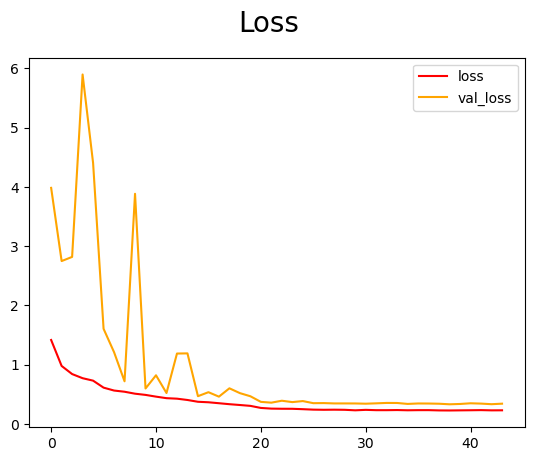

In [65]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

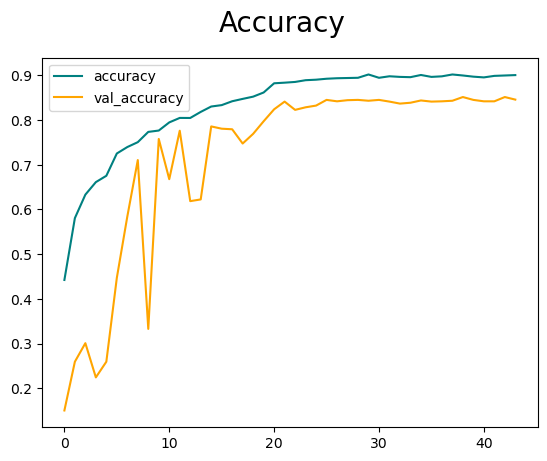

In [67]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [69]:
tf.keras.models.save_model(model,'my_model2_0_90_medium.hdf5')

In [243]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

10. Test

Testing

Found 1236 images belonging to 11 classes.


C:\Users\hemur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 777ms/step
Classification Report:

                            precision    recall  f1-score   support

                 1.Dry AMD       0.80      0.15      0.25        54
                 2.Wet AMD       0.88      0.10      0.17       156
                 3.Mild DR       0.27      1.00      0.42       179
             4.Moderate DR       0.00      0.00      0.00        23
               5.Severe DR       0.41      0.88      0.56       102
          6.Proliferate DR       0.76      0.40      0.52       216
                7.Cataract       0.70      0.71      0.71       107
8.Hypertensive Retinopathy       0.70      0.58      0.63        91
     9.Pathological Myopia       0.00      0.00      0.00       112
               10.Glaucoma       0.75      0.06      0.12        94
          11.Normal Fundus       1.00      0.10      0.18       102

                  accuracy                           0.42      1236
                 macro avg       0.57      0.36 

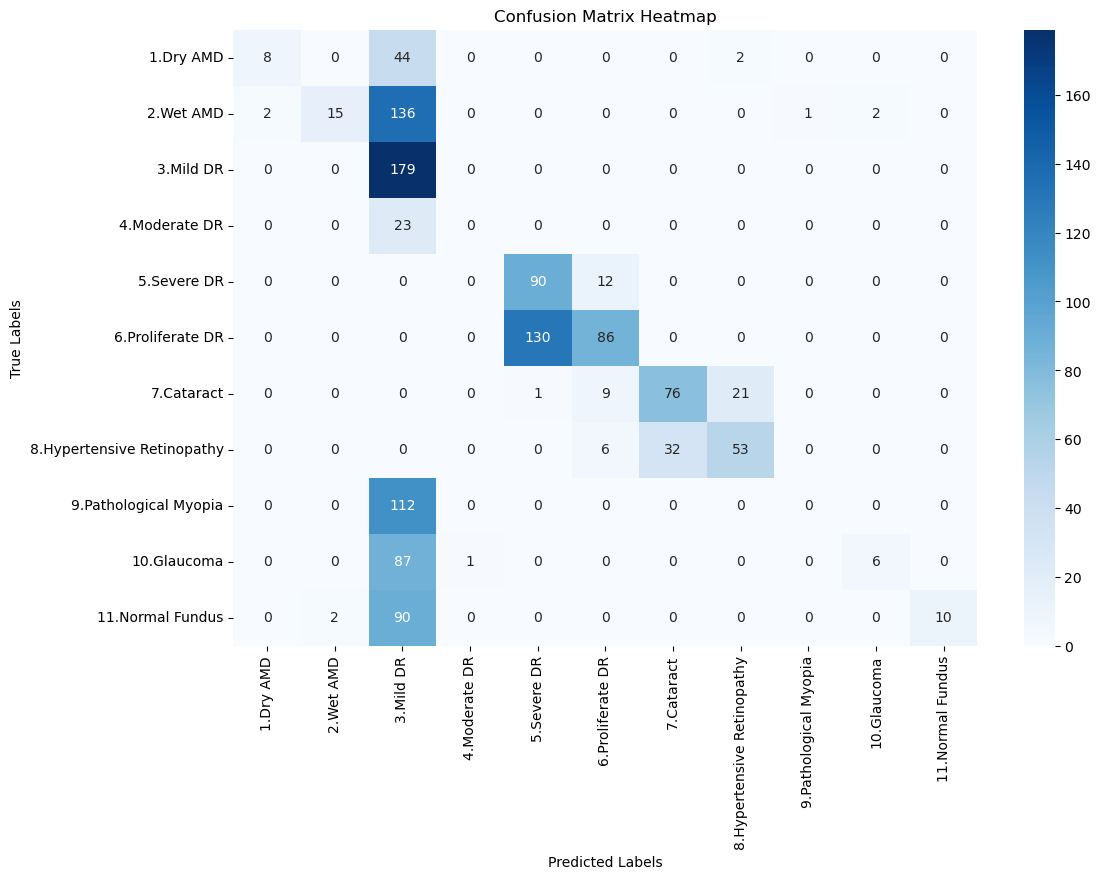

In [6]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved model
model = load_model('my_model2_0_90_medium.hdf5')

# Define class labels
class_labels = [
    '1.Dry AMD', '2.Wet AMD', '3.Mild DR', '4.Moderate DR', '5.Severe DR',
    '6.Proliferate DR', '7.Cataract', '8.Hypertensive Retinopathy',
    '9.Pathological Myopia', '10.Glaucoma', '11.Normal Fundus'
]

# Path to the testing dataset directory
test_data_dir = "C:/Retinal-image-analysis/Retinal Fundus Images/test"

# Preprocessing for the testing dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),  # Adjust to match your model's input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure order is consistent for evaluation
)

# Predict on the testing dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Save confusion matrix as a heatmap (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
